#Setup google colab file and import packages

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import numpy as np
import pandas as pd
import seaborn as sns
import re
import scipy
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn import linear_model
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import files
import math
import statistics


# Process Experimental Data

In [ ]:
##Import Information on How experiment was done
#wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/15UWWR2pui5c2WBkPUXZeoIe0W537cEGizOk3MJY850E/edit#gid=0')

#import experimental data

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1GblpjwolJDNkmA6BPQis4HaInOO9EFgLYzNSlW-mTf4/edit#gid=1948169317')

sheet = wb.sheet1
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
experimental_data = df.iloc[1:]



In [ ]:
#import rate constant data

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1HQol9hEEPu9hteW5msKt4EZz0kmE4c0RAL4Ki1s21Zg/edit#gid=595380466')

sheet = wb.sheet1
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df_rate_constants = df.iloc[1:]


## Rename and select important columns

In [ ]:
#extract rows from datasets that have attached label values
data = experimental_data.loc[experimental_data['data_for_modeling']=='1'].copy()

#rename important columns to ease further processing
#"kobs with new code":'k_obs'
data = data.rename(columns={"Virus name and strain": "virus_name", "Strain details": "strain","Temperature (C)":'temp', "Paper ID":'paper_ID',"Virus purification type":'purification_level'});
data = data.rename(columns={ "Chlorine Concentration" : "chlor_conc", "Sample ID" : "sample_ID","Year":"year", "Author_list_edit":"author_list", "Buffer description":"buffer_description", "average_kobs":"average_kobs_original"})
data = data.rename(columns={ "Ennumeration Cell Type" : "host_cell"})

#fill in incomplete values for strain and add a space
data['strain'] = data['strain'].fillna('').str.lower()
#make virus name lowercase
data['virus_name'] = data['virus_name'].str.lower()

#combine virus name and strain columns
data['virus_name_strain'] = data['virus_name'].str.replace("[ \t]+$",'', regex = True)+ ' ' + data['strain']

#extract only important columns
data = data.loc[:, ["virus_name","virus_name_strain","strain","temp", "pH", "paper_ID","purification_level", "chlor_conc", "sample_ID", "year", "author_list","buffer_type","corr_author","high_chloride", 'buffer_description', "host_cell", "high_chloride_new", 'phosphate_assumption_needed']]
#include average_kobs_original if I'm trying to do a comparison

##Calculate average kobs from two reviewers

In [ ]:
df_rate_constants.columns

Index(['Sample_ID', 'Method_R1', 'Coef_np_R1', 'Coef_OLS_R1',
       'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1', 'Data_Points_R1',
       'smaller_than_R1', 'Method_R2', 'Coef_np_R2', 'Coef_OLS_R2',
       'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2'],
      dtype='object', name=0)

In [ ]:
data = pd.merge(data.copy(), df_rate_constants, how = 'left',  left_on='sample_ID', right_on='Sample_ID')

#convert reviewer data to numeric
data['Coef_np_R1'] = np.abs(data['Coef_np_R1'].apply(pd.to_numeric))
data['Coef_np_R2'] = np.abs(data['Coef_np_R2'].apply(pd.to_numeric))
#data['average_kobs_original'] = np.abs(data['average_kobs_original'].apply(pd.to_numeric))

data["average_kobs"] = (data['Coef_np_R1'] + data['Coef_np_R2'])/2

#check if merge matches up with previously calculated average_kobs
#data2 = data.copy()[["kobs_mira", "kobs_kaming", "average_kobs_redo", "average_kobs"]]
#data2['diff'] = data2['average_kobs_redo'] - data2['average_kobs']
#data2[data2['diff']>.00005]


In [ ]:
# check that only data points manually observed to be fine are greater than 10% different

#kvalues = data.copy()
data['diff'] = (  np.abs(( data['Coef_np_R1'] - data['Coef_np_R2'] )) /data['Coef_np_R1']  )*100
diff10 = data[data['diff']>10]

fine_sampleid = ["31-9", '11-2', '35-8', '35-17', '35-20', '36-1', '36-3', '36-4', '41-6',
                 '41-10', '46-1', '46-2', '46-3', '46-4', '46-5', '46-6', '51-8', '51-10',
                 '59-2', '59-13', '60-10', '63-2', '81-4', '35-6', '46-8', '46-12', '46-13',
                 '51-18', '64-1','78-1', '35-12', '35-16', '35-18', '71-3', '54-6', '35-10','81-6']

diff10[~diff10['sample_ID'].isin(fine_sampleid)]


,virus_name,virus_name_strain,strain,temp,pH,paper_ID,purification_level,chlor_conc,sample_ID,year,...,Method_R2,Coef_np_R2,Coef_OLS_R2,Standard_Error_R2,Data_Points_Used_R2,Diff_R2,smaller_than_R2,larger_than_R2,average_kobs,diff


In [ ]:
diff10[~diff10['sample_ID'].isin(fine_sampleid)]


,virus_name,virus_name_strain,strain,temp,pH,paper_ID,purification_level,chlor_conc,sample_ID,year,...,Method_R2,Coef_np_R2,Coef_OLS_R2,Standard_Error_R2,Data_Points_Used_R2,Diff_R2,smaller_than_R2,larger_than_R2,average_kobs,diff


In [ ]:
data[data['sample_ID'] == '81-6']['Coef_np_R1']

569    1.137568
Name: Coef_np_R1, dtype: float64

# Lin's Concordance Calculation

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']

    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]

    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)


    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

def bootstrap_lin_ccc(y_true, y_pred, num_bootstrap_samples=1000):
    lin_ccc_samples = []
    n = len(y_true)

    for _ in range(num_bootstrap_samples):
        # Sample with replacement to create a bootstrap dataset
        boot_indices = np.random.choice(np.arange(n), n, replace=True)
        y_true_boot = y_true[boot_indices]
        y_pred_boot = y_pred[boot_indices]

        # Calculate Lin's CCC for the bootstrap dataset
        lin_ccc_boot = concordance_correlation_coefficient(y_true_boot, y_pred_boot)
        lin_ccc_samples.append(lin_ccc_boot)

    return np.array(lin_ccc_samples)


In [ ]:
# Using np.random.seed() instead of random.seed()
np.random.seed(42)

# Input kobs arrays here
kobs_mira_array = data['Coef_np_R1'].values
kobs_kaming_array = data['Coef_np_R2'].values

bootstrap_samples = bootstrap_lin_ccc(kobs_mira_array, kobs_kaming_array, num_bootstrap_samples=1000)

print("kobs 95% CI of the Lin's Concordance Coefficient (using bootstrap):")
scipy.stats.t.interval(confidence=0.95, df=len(bootstrap_samples)-1,
              loc=np.mean(bootstrap_samples),
              scale=np.std(bootstrap_samples))

kobs 95% CI of the Lin's Concordance Coefficient (using bootstrap):


(0.9944681767593133, 0.9995762087082207)

##Lin's Concordance and Plot

In [ ]:
data['diff_symbol'] = 9
data['diff_symbol'] = np.where(data['diff'] >10, "Larger than 10%", "Within 10%")


data.rename(columns = {
    'diff_symbol': 'Difference'
}, inplace=True)

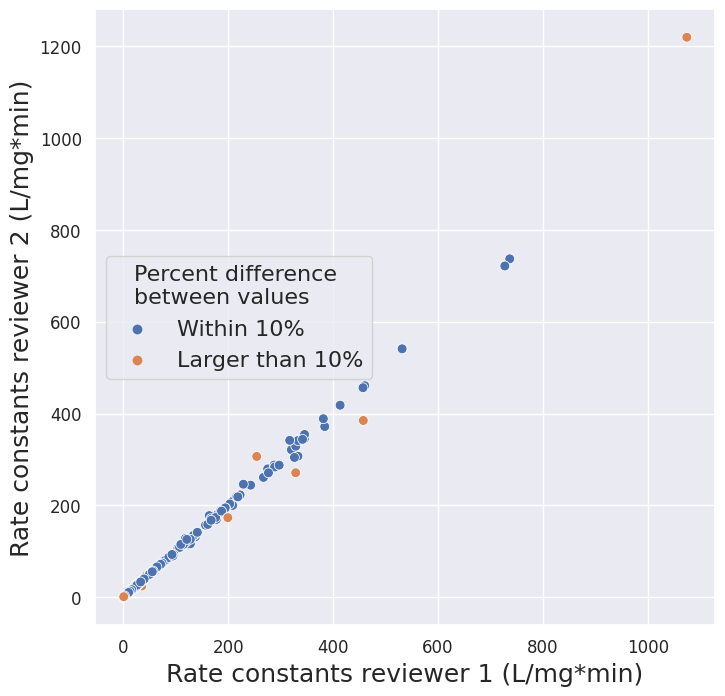

In [ ]:
sns.set(rc={'legend.loc': 'center left'})

plt.figure(figsize = (8,8))
sns.scatterplot(x = 'Coef_np_R1', y = 'Coef_np_R2', hue = 'Difference', data = data, s= 50)
plt.xlabel("Rate constants reviewer 1 (L/mg*min)", fontsize = 18)
plt.xticks(fontsize=12)
plt.ylabel("Rate constants reviewer 2 (L/mg*min)", fontsize = 18)
plt.yticks(fontsize=12)
plt.legend(title='Percent difference \nbetween values', fontsize=16, title_fontsize=16)
plt.show()

In [ ]:
len(data)

(len(data.paper_ID.unique()))

72

## Temperature and pH processing

In [ ]:
#convert ID from string
data['paper_ID'] = data['paper_ID'].apply(pd.to_numeric)

#replace temp with middle of temp range, and set room temp to 20 (68C)
data['temp'] = data['temp'].str.replace('20-25','22.5').str.replace('25-28','26.5').str.replace('25-26','25.5').str.replace('23-24','23.5').str.replace('1-5','3')
data['temp'] = data['temp'].str.replace('room temperature','20')

#convert numeric data to string
data['temp'] = data['temp'].apply(pd.to_numeric)
data['pH'] = data['pH'].apply(pd.to_numeric)

#find rate constant in terms of HOCl
pka = 7.53
data['alpha_0'] = 1/(1+ pow(10, -1* pka)/pow(10,-1*data['pH']) )

## Author and buffer processing

In [ ]:
data['buffer'] = data['buffer_type']

#make all buffers synthetic buffer
data['buffer'] = data['buffer'].str.replace('phosphate saline','synthetic_buffer').str.replace('acetate','synthetic_buffer').str.replace('borate','synthetic_buffer').str.replace('phosphate carbonate','synthetic_buffer')
data['buffer'] = data['buffer'].str.replace('calcium','synthetic_buffer').str.replace('carbonate','synthetic_buffer').str.replace('magnesium','synthetic_buffer').str.replace('phthlate','synthetic_buffer')
data['buffer'] = data['buffer'].str.replace('phosphate','synthetic_buffer')

#make natural and treated waters category
data['buffer'] = data['buffer'].str.replace('treated surface water','natural_or_treated_water').str.replace('tap water','natural_or_treated_water').str.replace('treated groundwater','natural_or_treated_water').str.replace('surface water','natural_or_treated_water')
data['buffer'] = data['buffer'].str.replace('treated water','natural_or_treated_water')

#make high organics category
data['buffer'] = data['buffer'].str.replace('lettuce wash water','high_organics').str.replace("wastewater","high_organics")



In [ ]:
len(data)
data['buffer'].unique()
data.columns

Index(['virus_name', 'virus_name_strain', 'strain', 'temp', 'pH', 'paper_ID',
       'purification_level', 'chlor_conc', 'sample_ID', 'year', 'author_list',
       'buffer_type', 'corr_author', 'high_chloride', 'buffer_description',
       'host_cell', 'high_chloride_new', 'phosphate_assumption_needed',
       'Sample_ID', 'Method_R1', 'Coef_np_R1', 'Coef_OLS_R1',
       'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1', 'Data_Points_R1',
       'smaller_than_R1', 'Method_R2', 'Coef_np_R2', 'Coef_OLS_R2',
       'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2', 'average_kobs', 'diff',
       'Difference', 'alpha_0', 'buffer'],
      dtype='object', name=0)

## Abbreviations and virus name cleaning

In [ ]:
import re
#data processing of experimental data

experiment = data.copy()

#replace virus full name with abbreviation in experiment dataset
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('poliovirus','pv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('coxsackievirus','cv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('echovirus','echo')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('human adenovirus','hadv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('adenovirus','hadv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('pepper mild mottle virus','pmmov')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('enterovirus','entero')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('hepatitis','hep')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('phi6','phi 6')

#remova trailing space
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)

#set all MS2 to be the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("ms2.*",'ms2', regex = True)

#set all cvb5 faulkner to be the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("faulkner.*",'faulkner', regex = True)

#remove unnecessart final identifyer
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" an mg845887",'').str.replace(" an mg845888",'').str.replace(" an mg845889",'')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" mg845890",'').str.replace(" mg845891",'').str.replace(" mg845892",'')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" mg845893",'').str.replace(" mg845894",'').str.replace(" mg845895",'')

#simplify name of pr772
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("baa-769-b1",'')

#assume that all hadv2 is the same, since vr-846 is the same as strain 6
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("vr-846",'strain 6').str.replace("strain 6","")

#remove dashes from cv
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("b5-",'b5 ').str.replace("b4-",'b4 ').str.replace("b1-",'b1 ')

#assumption: all cv b3 is cv b3 nancy
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("cv b3",'cv b3 nancy').str.replace("nancy nancy",'nancy')

#remove prd1 strain designation (only using one)
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("dsm 19107",'')

#assumption: all phi6 is the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("phi 6 atcc 21781-b1",'phi 6')

#remove fr strain designation, add bacteriophage to fr and ga
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("atcc 15767-b1",'bacteriophage')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("ga(\W|$)",'ga bacteriophage', regex = True)

#replace h1n1 h1n1 strain a/pr/8/34 vr-1469 with simpler
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("h1n1 strain a/pr/8/34 vr-1469",'h1n1 a/pr/8/34', regex = True)

#assumption: replace 77-1 cv b4 with cvb4 jvb (since this is a lab strain)
experiment["virus_name_strain"] = np.where(experiment["sample_ID"]=="77-1",'cv b4 jvb', experiment["virus_name_strain"])

#assumption: pv2 P712 is vaccine strain
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("pv 2 p712",'pv 2 sabin', regex = True)

#assumption: all hadv 41 is hadv 41 tak
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("hadv 41.*",'hadv 41 tak', regex = True)

#assumption: reovirus 3 lang is actually reovirus 1 lang, since the Lang strain is reovirus 1
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("reovirus 3 lang",'reovirus 1 lang', regex = True)

#assumption: all murine norovirus that is not PR772 is mnv 1 (see virus info spreadsheet)
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("murine norovirus(?!\s)",'murine norovirus 1', regex = True)

#assumption: manually assign cv B5 in Payment 1985 to Faulkner
experiment["virus_name_strain"] = np.where(experiment["sample_ID"]=="77-2",'cv b5 faulkner', experiment["virus_name_strain"])

#assumption: assume that all mnv except that specifically not designated is mnv 1
experiment['virus_name_strain'].str.replace("murine norovirus(?!\s)",'murine norovirus 1', regex = True)

#remove trailing spaces
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)

#(sorted(experiment.virus_name_strain.unique()))


In [ ]:
len(sorted(experiment.virus_name_strain.unique()))
experiment.columns

Index(['virus_name', 'virus_name_strain', 'strain', 'temp', 'pH', 'paper_ID',
       'purification_level', 'chlor_conc', 'sample_ID', 'year', 'author_list',
       'buffer_type', 'corr_author', 'high_chloride', 'buffer_description',
       'host_cell', 'high_chloride_new', 'phosphate_assumption_needed',
       'Sample_ID', 'Method_R1', 'Coef_np_R1', 'Coef_OLS_R1',
       'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1', 'Data_Points_R1',
       'smaller_than_R1', 'Method_R2', 'Coef_np_R2', 'Coef_OLS_R2',
       'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2', 'average_kobs', 'diff',
       'Difference', 'alpha_0', 'buffer'],
      dtype='object', name=0)

# Process Virus Reference Data

In [ ]:
#import virus data URL
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/16WAf0KTSKRTIjwbluDqyqbhq1JXRkUioS_QzqwqpPGM/edit#gid=1024744371')
sheet = wb.worksheet('Virus Details Final')
data2 = sheet.get_all_values()
df = pd.DataFrame(data2)
df.columns = df.iloc[0]
virus_data = df.iloc[1:]

## Rename and select important columns


In [ ]:
#rename important columns
virus_data = virus_data.rename(columns={"Virus Name": "virus_name", "Baltimore Class": "balt_class", "Genome shape":'shape', "Family":'family',"Genus":'genus', "Strain":'strain'})
virus_data = virus_data.rename(columns={"Structure":'structure',"Tail":'tail',"Isoelectric Point": 'iep', "Species":'species', "Symmetry":'symmetry', "Tail":'tail'})
virus_data['virus_name_strain'] = virus_data['virus_name'].str.replace("[ \t]+$",'', regex = True) + ' ' + virus_data['strain']
virus_data['min_diameter'] = pd.to_numeric(virus_data['min_diameter'])
virus_data['max_diameter']= pd.to_numeric(virus_data['max_diameter'])
virus_data['diameter'] = (virus_data['min_diameter'] + virus_data['max_diameter'])/2
virus_data['genome_length'] = pd.to_numeric(virus_data['genome_length'])

#take the average of min and max diameter to get diameter

reference = virus_data.loc[:, ["virus_name_strain","balt_class","family","genus","species","shape","structure","symmetry","tail","diameter","CG_content","genome_length","C_percentage", "G_percentage", "A_percentage", "T_percentage", "U_percentage", "T_is_0", "U_is_0"]]

#reference = virus_data.loc[:,"virus_name_strain","balt_class","family","genus","species","shape","iep","structure","symmetry","tail","diameter","CG_content","genome_length","C_percentage", "G_percentage", "A_percentage", "T_percentage", "U_percentage", "T_is_0", "U_is_0"]

#make colums lowercase
reference['virus_name_full'] = reference['virus_name_strain']
reference['virus_name_strain'] = reference['virus_name_strain'].str.lower()
reference['structure'] = reference['structure'].str.lower()

#remove trailing space
reference['shape']  = reference['shape'].str.replace("[ \t]+$",'', regex = True)


#replace other virus characteristics
reference['balt_class'] = reference['balt_class'].str.replace('-senseRNA','-ssRNA')



In [ ]:
len(np.unique(reference['virus_name_full']))

90

## Abbreviations and virus name cleaning

In [ ]:
#data processing of reference data

#replace virus full name with abbreviation in experiment dataset
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('poliovirus','pv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('coxsackievirus','cv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('echovirus','echo')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('human adenovirus','hadv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('adenovirus','hadv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('pepper mild mottle virus','pmmov')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('enterovirus','entero')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('hepatitis','hep')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('phi6','phi 6')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('none','')

#decided to use only one ms2, so i will remove identifyer
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("atcc 15597-b1",'')

#general mods
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("phi 6 phage",'phi 6')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("2-85",'')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("hep e virus",'hep e').str.replace("hep a virus",'hep a').str.replace("sar 55",'sar55')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace(" 7a,",'')

#assume all hadv2 is same
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("hadv 2 strain 6",'hadv 2')

#remove trailing space
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)


In [ ]:
#reference.to_excel("virus_information.xlsx")
#files.download("virus_information.xlsx")


In [ ]:
#sorted(np.unique(reference['virus_name_strain']))

# Merge Datasets

In [ ]:
experiment.columns

Index(['virus_name', 'virus_name_strain', 'strain', 'temp', 'pH', 'paper_ID',
       'purification_level', 'chlor_conc', 'sample_ID', 'year', 'author_list',
       'buffer_type', 'corr_author', 'high_chloride', 'buffer_description',
       'host_cell', 'high_chloride_new', 'phosphate_assumption_needed',
       'Sample_ID', 'Method_R1', 'Coef_np_R1', 'Coef_OLS_R1',
       'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1', 'Data_Points_R1',
       'smaller_than_R1', 'Method_R2', 'Coef_np_R2', 'Coef_OLS_R2',
       'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2', 'average_kobs', 'diff',
       'Difference', 'alpha_0', 'buffer'],
      dtype='object', name=0)

In [ ]:
#merge dataset, using experimental data as key
merged_dataset = pd.merge(experiment, reference, how = 'left',  left_on='virus_name_strain', right_on='virus_name_strain')

#drop extraneous virus name column
merged_dataset = merged_dataset.drop(columns=['virus_name', 'strain'])



In [ ]:
merged_dataset.columns

Index(['virus_name_strain', 'temp', 'pH', 'paper_ID', 'purification_level',
       'chlor_conc', 'sample_ID', 'year', 'author_list', 'buffer_type',
       'corr_author', 'high_chloride', 'buffer_description', 'host_cell',
       'high_chloride_new', 'phosphate_assumption_needed', 'Sample_ID',
       'Method_R1', 'Coef_np_R1', 'Coef_OLS_R1', 'Standard_Error_R1',
       'Data_Points_Used_R1', 'Diff_R1', 'Data_Points_R1', 'smaller_than_R1',
       'Method_R2', 'Coef_np_R2', 'Coef_OLS_R2', 'Standard_Error_R2',
       'Data_Points_Used_R2', 'Diff_R2', 'smaller_than_R2', 'larger_than_R2',
       'average_kobs', 'diff', 'Difference', 'alpha_0', 'buffer', 'balt_class',
       'family', 'genus', 'species', 'shape', 'structure', 'symmetry', 'tail',
       'diameter', 'CG_content', 'genome_length', 'C_percentage',
       'G_percentage', 'A_percentage', 'T_percentage', 'U_percentage',
       'T_is_0', 'U_is_0', 'virus_name_full'],
      dtype='object', name=0)

In [ ]:
phi_string = '\u03C6X174 bacteriophage'
print(phi_string)


φX174 bacteriophage


##Manage virus full names and abbreviations

In [ ]:
merge_test = merged_dataset.copy()

merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace(' none','')
#remove trailing space
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace("[ \t]+$",'', regex = True)

#add bacteriophage before each bacteriophage
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Bacteriophage B40-8','B40-8 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('PR772','PR772 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('PRD1','PRD1 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('T2','T2 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('T5','T5 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('fr Bacteriophage','fr bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Coxsackievirus','coxsackievirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Echovirus','echovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Enterovirus','enterovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Feline Calicivirus','feline calicivirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Virus','virus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Hepatitis','hepatitis')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Human Adenovirus','human adenovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Human Rotavirus','human rotavirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Rat','rat')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Infectious Pancreatic Necrosis virus Powder mill strain','infectious pancreatic necrosis virus Powder Mill strain')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Infectious hematopoietic necrosis virus Wenatchee river strain','infectious hematopoietic necrosis virus Wenatchee River strain')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Murine Norovirus','murine norovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Parvovirus','parvovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Phi 6 phage','\u03C66 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Poliovirus','poliovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Qbeta','Q\u03B2 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Phi X-174 ATCC 13706-B1','\u03C6X174 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Reovirus','reovirus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Rhesus','rhesus')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('Simian','simian')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('MS2 ATCC 15597-B1','MS2 bacteriophage')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('H1N1 A/PR/8/34','influenza A/PR/8/34 (H1N1)')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('H5N1 A/Chicken/Hong Kong/D-0947/2006','highly pathogenic avian influenza A/Chicken/Hong Kong/D-0947/2006 (H5N1)')
merge_test['virus_name_full'] = merge_test['virus_name_full'].str.replace('H5N1 A/WhooperSwan/Mongolia/244/2005','highly pathogenic avian influenza A/WhooperSwan/Mongolia/244/2005 (H5N1)')


print(len(np.unique(merge_test['virus_name_full'])))
(np.unique(merge_test['virus_name_full']))

82


array(['B40-8 bacteriophage', 'GA Bacteriophage', 'Kilham rat virus',
       'MS2 bacteriophage', 'PR772 bacteriophage', 'PRD1 bacteriophage',
       'Qβ bacteriophage', 'T2 bacteriophage', 'T5 bacteriophage',
       'coxsackievirus A24 EH24/70', 'coxsackievirus A5 Swartz',
       'coxsackievirus A9', 'coxsackievirus A9 Griggs',
       'coxsackievirus A9 PB Bozek', 'coxsackievirus B1 49683',
       'coxsackievirus B1 Conn-5', 'coxsackievirus B1 L071715',
       'coxsackievirus B2', 'coxsackievirus B3 Nancy',
       'coxsackievirus B4 JVB', 'coxsackievirus B4 M063015',
       'coxsackievirus B4 T051217', 'coxsackievirus B5',
       'coxsackievirus B5 EA 80', 'coxsackievirus B5 Faulkner',
       'coxsackievirus B5 L030315', 'coxsackievirus B5 L060815',
       'coxsackievirus B5 L061815', 'coxsackievirus B5 L070215',
       'coxsackievirus B5 L070915', 'coxsackievirus B5 M063015',
       'echovirus 1 Farouk', 'echovirus 11 Gregory',
       'echovirus 12 Travis 2-85', 'echovirus 29 JV-10',

In [ ]:
#add corrected full names to merged dataset
merged_dataset['virus_name_full'] = merge_test['virus_name_full']

#check merged dataset for missing values
print(merged_dataset[merged_dataset['buffer'].isnull()])
print(merged_dataset[merged_dataset['balt_class'].isnull()])

len(np.unique(merged_dataset['virus_name_strain']))




Empty DataFrame
Columns: [virus_name_strain, temp, pH, paper_ID, purification_level, chlor_conc, sample_ID, year, author_list, buffer_type, corr_author, high_chloride, buffer_description, host_cell, high_chloride_new, phosphate_assumption_needed, Sample_ID, Method_R1, Coef_np_R1, Coef_OLS_R1, Standard_Error_R1, Data_Points_Used_R1, Diff_R1, Data_Points_R1, smaller_than_R1, Method_R2, Coef_np_R2, Coef_OLS_R2, Standard_Error_R2, Data_Points_Used_R2, Diff_R2, smaller_than_R2, larger_than_R2, average_kobs, diff, Difference, alpha_0, buffer, balt_class, family, genus, species, shape, structure, symmetry, tail, diameter, CG_content, genome_length, C_percentage, G_percentage, A_percentage, T_percentage, U_percentage, T_is_0, U_is_0, virus_name_full]
Index: []

[0 rows x 57 columns]
Empty DataFrame
Columns: [virus_name_strain, temp, pH, paper_ID, purification_level, chlor_conc, sample_ID, year, author_list, buffer_type, corr_author, high_chloride, buffer_description, host_cell, high_chloride_n

82

## Revisions: Virus Abbreviations

In [ ]:

# based on https://wwwnc.cdc.gov/eid/page/scientific-nomenclature

merge_test = merged_dataset.copy()
merge_test['virus_name_abbrev'] = merge_test['virus_name_full']

#replace coxsackievirus with CV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('coxsackievirus ','CV')

#replace numbered echovirus with E_number
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('echovirus ','E')

#replace numbered enterovirus with EV_number
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('enterovirus 70 AHC\\(J670/71\\)','EV70')

#replace hepatitis E virus with HEV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('hepatitis E virus','HEV')

#replace hepatitis A virus with HAV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('hepatitis A virus','HAV')

#replace human adenovirus with HAV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('human adenovirus','HAdV')

#replace human rotavirus with HRV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('human rotavirus','HRV')

#replace poliovirus with PV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('poliovirus ','PV')

#replace feline calcivirus with FCV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('feline calicivirus','FCV')

#replace infectious hematopoietic necrosis virus Wenatchee River strain with IHNV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('infectious hematopoietic necrosis virus Wenatchee River strain','IHNV')

#replace infectious pancreatic necrosis virus Powder Mill strain with IPNV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('infectious pancreatic necrosis virus Powder Mill strain','IPNV')

#replace murine norovirus with MNV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('murine norovirus','MNV')

#replace simian virus 40 with SV40
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('simian virus 40','SV40')

#replace reovirus with REO
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('reovirus','REO')

#replace rhesus rotavirus with RRV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('rhesus rotavirus','RRV')

#replace 'influenza A/PR/8/34 (H1N1)', WITH IAV (H1N1)
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('influenza A/PR/8/34 \\(H1N1\\)','IAV (H1N1)')

#replace highly pathogenic avian influenza A/Chicken/Hong Kong/D-0947/2006 (H5N1), WITH HPAI A/.../2006
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('highly pathogenic avian influenza A/Chicken/Hong Kong/D-0947/2006 \\(H5N1\\)','HPAI A/.../2006')

#replace 'highly pathogenic avian influenza A/WhooperSwan/Mongolia/244/2005 (H5N1)', WITH HPAI A/.../2005
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('highly pathogenic avian influenza A/WhooperSwan/Mongolia/244/2005 \\(H5N1\\)','HPAI A/.../2005')

#replace simian rotavirus with SRV
merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('simian rotavirus','SRV')


print(len(np.unique(merge_test['virus_name_abbrev'])))
(np.unique(merge_test['virus_name_abbrev']))

82


<ipython-input-33-520655a280af>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('enterovirus 70 AHC\\(J670/71\\)','EV70')
<ipython-input-33-520655a280af>:52: FutureWarning: The default value of regex will change from True to False in a future version.
  merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('influenza A/PR/8/34 \\(H1N1\\)','IAV (H1N1)')
<ipython-input-33-520655a280af>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  merge_test['virus_name_abbrev'] = merge_test['virus_name_abbrev'].str.replace('highly pathogenic avian influenza A/Chicken/Hong Kong/D-0947/2006 \\(H5N1\\)','HPAI A/.../2006')
<ipython-input-33-520655a280af>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  merge_test['virus_name_abbrev'] = merge_test['virus

array(['B40-8 bacteriophage', 'CVA24 EH24/70', 'CVA5 Swartz', 'CVA9',
       'CVA9 Griggs', 'CVA9 PB Bozek', 'CVB1 49683', 'CVB1 Conn-5',
       'CVB1 L071715', 'CVB2', 'CVB3 Nancy', 'CVB4 JVB', 'CVB4 M063015',
       'CVB4 T051217', 'CVB5', 'CVB5 EA 80', 'CVB5 Faulkner',
       'CVB5 L030315', 'CVB5 L060815', 'CVB5 L061815', 'CVB5 L070215',
       'CVB5 L070915', 'CVB5 M063015', 'E1 Farouk', 'E11 Gregory',
       'E12 Travis 2-85', 'E29 JV-10', 'E5 Noyce', "E6 D'Amori",
       'E7 Wallace', 'E9 Vispo', 'EV70', 'FCV F9', 'GA Bacteriophage',
       'HAV HM175', 'HAV MBB', 'HAdV 12 Huie', 'HAdV 2 strain 6',
       'HAdV 3 G.B.', 'HAdV 40 Dugan', 'HAdV 41 tak', 'HAdV 5',
       'HAdV 7a S-1058', 'HEV Sar 55', 'HPAI A/.../2005',
       'HPAI A/.../2006', 'HRV Ito P13', 'HRV Wa', 'IAV (H1N1)', 'IHNV',
       'IPNV', 'Kilham rat virus', 'MNV 1', 'MNV S7-PP3',
       'MS2 bacteriophage', 'PR772 bacteriophage', 'PRD1 bacteriophage',
       'PV1 487', 'PV1 Brunhilde', 'PV1 MK 500', 'PV1 Mahoney

In [ ]:
#add corrected abbreviations to merged)dataset

merged_dataset['virus_name_abbrev'] = merge_test['virus_name_abbrev']


##Old: virus_name_strain

In [ ]:
#process virus name columns
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('infectious pancreatic necrosis virus powder mill strain','ipnv')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('infectious hematopoietic necrosis virus wenatchee river strain','ihnv')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('h5n1 a/chicken/hong kong/d-0947/2006','h5n1 hk')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('h5n1 a/whooperswan/mongolia/244/2005','h5n1 mongolia')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('bacteriophage b40-8','b40-8')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('cv a24 eh24/70','cv a24')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('entero 70 ahc\\(j670/71\\)','entero 70')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('f2 bacteriophage','f2')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('ga bacteriophage','ga')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('fr bacteriophage','fr')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('feline calicivirus f9','fcv f9')

merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('h1n1 a/pr/8/34','h1n1 pr')

merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('hadv 7a s-1058','hadv 7a')

merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('human rotavirus','hrv')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('murine norovirus','mnv')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('rhesus rotavirus','rrv')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('reovirus','reo')
merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('phi x-174 atcc 13706-b1','phi x-174')


<ipython-input-35-3d6104a9cbd6>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_dataset['virus_name_strain'] = merged_dataset['virus_name_strain'].str.replace('entero 70 ahc\\(j670/71\\)','entero 70')


## Modify author list

In [ ]:
def get_author_list(str_list):
    str_list = str_list.replace('[', "")
    str_list = str_list.replace(']', "")
    str_list = str_list.replace("'", "")
    return str_list


merged_dataset['corr_author'] = merged_dataset['corr_author'].apply(get_author_list)
#merged_dataset['corr_author'].value_counts()

In [ ]:
merged_dataset['author_list']

0        ['young_s', 'torrey_j', 'bachmann_v', 'kohn_t']
1        ['young_s', 'torrey_j', 'bachmann_v', 'kohn_t']
2      ['shirasaki_n', 'matsushita_t', 'matsui_y', 'k...
3      ['shirasaki_n', 'matsushita_t', 'matsui_y', 'k...
4      ['wati_s', 'robinson_b', 'mieog_j', 'blackbear...
                             ...                        
565               ['wedemeyer_g', 'nelson_n', 'smith_c']
566               ['wedemeyer_g', 'nelson_n', 'smith_c']
567               ['wedemeyer_g', 'nelson_n', 'smith_c']
568               ['wedemeyer_g', 'nelson_n', 'smith_c']
569               ['wedemeyer_g', 'nelson_n', 'smith_c']
Name: author_list, Length: 570, dtype: object

In [ ]:
import ast

merged_dataset['first_author'] = merged_dataset['author_list'].apply(ast.literal_eval).apply(lambda x: x[0])
merged_dataset['first_author_and_year'] = merged_dataset['first_author'] + ' ' + merged_dataset['year']
merged_dataset['first_author_and_year']

0          young_s 2020
1          young_s 2020
2      shirasaki_n 2020
3      shirasaki_n 2020
4           wati_s 2019
             ...       
565    wedemeyer_g 1978
566    wedemeyer_g 1978
567    wedemeyer_g 1978
568    wedemeyer_g 1978
569    wedemeyer_g 1978
Name: first_author_and_year, Length: 570, dtype: object

In [ ]:
# remove extraneous features from dataset
merged_dataset = merged_dataset[[f for f in merged_dataset.columns if f not in ['Unnamed: 0', 'kobs_mira','kobs_kaming', 'chlor_conc', 'shape', 'iep']]]
merged_dataset.head()

,virus_name_strain,temp,pH,paper_ID,purification_level,sample_ID,year,author_list,buffer_type,corr_author,...,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0,virus_name_full,virus_name_abbrev,first_author,first_author_and_year
0,cv b5 faulkner,20.0,7.5,2,2,2-1,2020,"['young_s', 'torrey_j', 'bachmann_v', 'kohn_t']",phosphate saline,kohn_t,...,24.7973,28.32432,0,23.90541,1,0,coxsackievirus B5 Faulkner,CVB5 Faulkner,young_s,young_s 2020
1,echo 11 gregory,20.0,7.5,2,2,2-2,2020,"['young_s', 'torrey_j', 'bachmann_v', 'kohn_t']",phosphate saline,kohn_t,...,24.36139,28.09895,0,23.75639,1,0,echovirus 11 Gregory,E11 Gregory,young_s,young_s 2020
2,cv b5 faulkner,20.0,7.0,3,2,3-1,2020,"['shirasaki_n', 'matsushita_t', 'matsui_y', 'k...",phosphate saline,shirasaki_n,...,24.7973,28.32432,0,23.90541,1,0,coxsackievirus B5 Faulkner,CVB5 Faulkner,shirasaki_n,shirasaki_n 2020
3,cv b5 faulkner,20.0,7.0,3,2,3-2,2020,"['shirasaki_n', 'matsushita_t', 'matsui_y', 'k...",phosphate saline,shirasaki_n,...,24.7973,28.32432,0,23.90541,1,0,coxsackievirus B5 Faulkner,CVB5 Faulkner,shirasaki_n,shirasaki_n 2020
4,cv b5 faulkner,10.0,7.0,5,2,5-1,2019,"['wati_s', 'robinson_b', 'mieog_j', 'blackbear...",wastewater,keegan_a,...,24.7973,28.32432,0,23.90541,1,0,coxsackievirus B5 Faulkner,CVB5 Faulkner,wati_s,wati_s 2019


In [ ]:
# Take log of the kobs
merged_dataset['log_average_kobs'] = np.log10(merged_dataset['average_kobs'])


In [ ]:
np.min(merged_dataset['log_average_kobs'])

-1.7077145325551433

## Scale Year

In [ ]:
merged_dataset['year'] = merged_dataset['year'].str.replace('b', '')
np.sort(merged_dataset['year'].unique())

array(['1958', '1971', '1973', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1988', '1989', '1990',
       '1991', '1994', '1995', '1996', '1998', '2003', '2004', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'], dtype=object)

In [ ]:
middle_year = float((1958 + 2020)/2)

merged_dataset['year_float'] = merged_dataset['year'].astype("float")
merged_dataset['year_int'] = merged_dataset['year'].astype("int")

merged_dataset['float_year_scaled'] = (merged_dataset['year_float'] - middle_year)/10
merged_dataset['int_year_scaled'] = (merged_dataset['year_int'] - middle_year)/10

In [ ]:
#(sorted(experiment.virus_name_strain.unique()))

In [ ]:
(np.unique(merged_dataset['virus_name_full']))

array(['B40-8 bacteriophage', 'GA Bacteriophage', 'Kilham rat virus',
       'MS2 bacteriophage', 'PR772 bacteriophage', 'PRD1 bacteriophage',
       'Qβ bacteriophage', 'T2 bacteriophage', 'T5 bacteriophage',
       'coxsackievirus A24 EH24/70', 'coxsackievirus A5 Swartz',
       'coxsackievirus A9', 'coxsackievirus A9 Griggs',
       'coxsackievirus A9 PB Bozek', 'coxsackievirus B1 49683',
       'coxsackievirus B1 Conn-5', 'coxsackievirus B1 L071715',
       'coxsackievirus B2', 'coxsackievirus B3 Nancy',
       'coxsackievirus B4 JVB', 'coxsackievirus B4 M063015',
       'coxsackievirus B4 T051217', 'coxsackievirus B5',
       'coxsackievirus B5 EA 80', 'coxsackievirus B5 Faulkner',
       'coxsackievirus B5 L030315', 'coxsackievirus B5 L060815',
       'coxsackievirus B5 L061815', 'coxsackievirus B5 L070215',
       'coxsackievirus B5 L070915', 'coxsackievirus B5 M063015',
       'echovirus 1 Farouk', 'echovirus 11 Gregory',
       'echovirus 12 Travis 2-85', 'echovirus 29 JV-10',

In [ ]:
merged_dataset.columns

Index(['virus_name_strain', 'temp', 'pH', 'paper_ID', 'purification_level',
       'sample_ID', 'year', 'author_list', 'buffer_type', 'corr_author',
       'high_chloride', 'buffer_description', 'host_cell', 'high_chloride_new',
       'phosphate_assumption_needed', 'Sample_ID', 'Method_R1', 'Coef_np_R1',
       'Coef_OLS_R1', 'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1',
       'Data_Points_R1', 'smaller_than_R1', 'Method_R2', 'Coef_np_R2',
       'Coef_OLS_R2', 'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2', 'average_kobs', 'diff',
       'Difference', 'alpha_0', 'buffer', 'balt_class', 'family', 'genus',
       'species', 'structure', 'symmetry', 'tail', 'diameter', 'CG_content',
       'genome_length', 'C_percentage', 'G_percentage', 'A_percentage',
       'T_percentage', 'U_percentage', 'T_is_0', 'U_is_0', 'virus_name_full',
       'virus_name_abbrev', 'first_author', 'first_author_and_year',
       'log_average_kobs', 'y

##Manage host cell grouping

In [ ]:
merged_dataset.host_cell


0       BGMK
1       BGMK
2       BGMK
3       BGMK
4       BGMK
       ...  
565    RTG-2
566    RTG-2
567    RTG-2
568      FHM
569      FHM
Name: host_cell, Length: 570, dtype: object

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/15UWWR2pui5c2WBkPUXZeoIe0W537cEGizOk3MJY850E/edit#gid=0')

sheet = wb.sheet1
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
old_host_data = df.iloc[1:]

old_host_data = old_host_data.loc[old_host_data['data_for_modeling']=='1'].copy()



In [ ]:
only_imp_cols_old = old_host_data[['Sample ID','Ennumeration Cell Type','pH']]

only_imp_cols_new = merged_dataset[['sample_ID','host_cell']]

all_imp_cols = only_imp_cols_new.merge(only_imp_cols_old,left_on='sample_ID', right_on='Sample ID')

In [ ]:
all_imp_cols[all_imp_cols['host_cell']!=all_imp_cols['Ennumeration Cell Type']]

,sample_ID,host_cell,Sample ID,Ennumeration Cell Type,pH
72,21-1,HepG2/C3A cells (CRL-10741),21-1,HepG2/C3A cells (CRL-10741),8
73,21-2,HepG2/C3A cells (CRL-10741),21-2,HepG2/C3A cells (CRL-10741),8


In [ ]:
##Manage host cell grouping
merged_dataset_temp = merged_dataset.copy()
merged_dataset_temp['host_grouping'] = merged_dataset_temp['host_cell']

#group all E. coli together, all S. Typhimurium together, all P. synringae together
merged_dataset_temp['host_grouping'] = merged_dataset_temp['host_grouping'].str.replace(r'E\. coli.*', 'E. coli', regex=True)
merged_dataset_temp['host_grouping'] = merged_dataset_temp['host_grouping'].str.replace(r'S\. Typhimurium.*', 'S. Typhimurium', regex=True)
merged_dataset_temp['host_grouping'] = merged_dataset_temp['host_grouping'].str.replace(r'A549', 'HLC A549', regex=True)
merged_dataset_temp['host_grouping'] = merged_dataset_temp['host_grouping'].str.replace(r'P\. syringae.*', 'P. syringae', regex=True)


#assume that E. coli was the host cell for all studied f2 coliphage
merged_dataset_temp.loc[merged_dataset_temp['paper_ID']==64, 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-3', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-4', 'host_grouping'] = 'E. coli'

#assume that E. coli was the host cell for all ms2 coliphage that was not labelled, as this is standard
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='9-1', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='43-1', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-5', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-6', 'host_grouping'] = 'E. coli'

#assume that E. coli was the host cell for t2 and t5 coliphage
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-9', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-11', 'host_grouping'] = 'E. coli'
merged_dataset_temp.loc[merged_dataset_temp['sample_ID']=='69-10', 'host_grouping'] = 'E. coli'


#set all primary monkey kidney cells to be primary monkey kidney cells
merged_dataset_temp.loc[merged_dataset_temp['host_grouping']=='primary rhesus monkey kidney', 'host_grouping'] = 'primary monkey kidney cells'
merged_dataset_temp.loc[merged_dataset_temp['host_grouping']=='primary vervet kidney cells', 'host_grouping'] = 'primary monkey kidney cells'


#set all HEK cells to HEK
merged_dataset_temp.loc[merged_dataset_temp['host_grouping']=='HEK 293', 'host_grouping'] = 'HEK'
merged_dataset_temp.loc[merged_dataset_temp['host_grouping']=='293A', 'host_grouping'] = 'HEK'

merged_dataset = merged_dataset_temp


In [ ]:
merged_dataset_temp.groupby('virus_name_abbrev')['host_grouping'].nunique().reset_index()


,virus_name_abbrev,host_grouping
0,B40-8 bacteriophage,1
1,CVA24 EH24/70,1
2,CVA5 Swartz,1
3,CVA9,1
4,CVA9 Griggs,1
...,...,...
77,f2 bacteriophage,1
78,fr bacteriophage,1
79,parvovirus H-1,1
80,φ6 bacteriophage,1


In [ ]:
merged_dataset[merged_dataset['host_cell'].isnull()]
merged_dataset_temp.loc[merged_dataset_temp['host_grouping']=='',:]


,virus_name_strain,temp,pH,paper_ID,purification_level,sample_ID,year,author_list,buffer_type,corr_author,...,virus_name_full,virus_name_abbrev,first_author,first_author_and_year,log_average_kobs,year_float,year_int,float_year_scaled,int_year_scaled,host_grouping


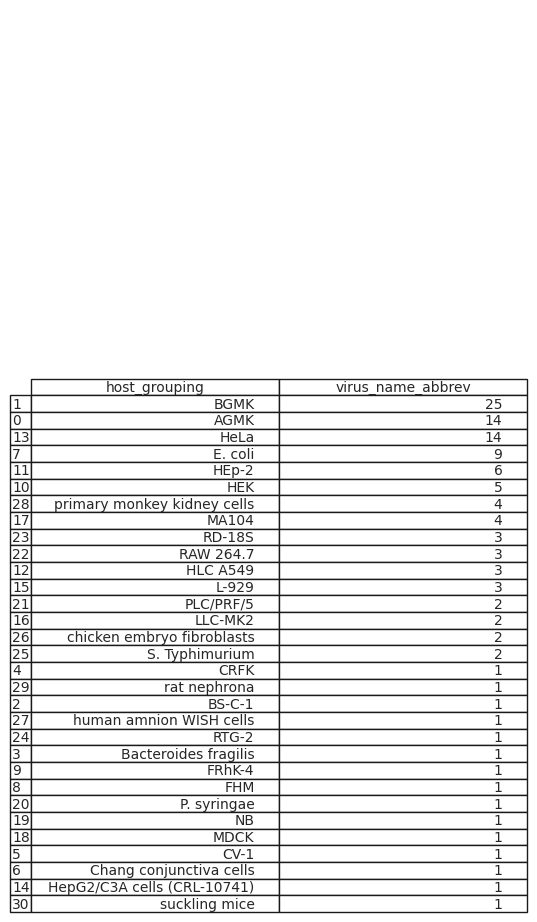

In [ ]:
#(merged_dataset_temp.groupby('virus_name_abbrev')['host_grouping'].unique().reset_index())
host_grouping_unique = merged_dataset_temp.groupby('host_grouping')['virus_name_abbrev'].nunique().reset_index()
host_grouping_unique = host_grouping_unique.sort_values(by = 'virus_name_abbrev', ascending=False)


ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, host_grouping_unique)  # where df is your data frame

#plt.savefig('mytable.png')


In [ ]:
#host_grouping_unique.groupby('virus_name_strain').nunique()

In [ ]:
virus_grouping_unique = merged_dataset_temp.groupby('virus_name_strain')['host_grouping'].nunique().reset_index()
virus_grouping_unique = virus_grouping_unique.sort_values(by = 'host_grouping', ascending=False)
#virus_grouping_unique.to_csv('virus_grouping_unique.csv')
#from google.colab import files
#files.download('virus_grouping_unique.csv')
virus_grouping_unique

,virus_name_strain,host_grouping
64,pv 1 mahoney,6
66,pv 1 sabin,5
10,cv b3 nancy,4
44,hadv 5,3
70,pv 2 sabin,3
...,...,...
30,echo 9 vispo,1
29,echo 7 wallace,1
28,echo 6 d'amori,1
27,echo 5 noyce,1


In [ ]:
virus_grouping_unique.groupby('host_grouping').nunique()

,virus_name_strain
host_grouping,
1,63
2,10
3,6
4,1
5,1
6,1


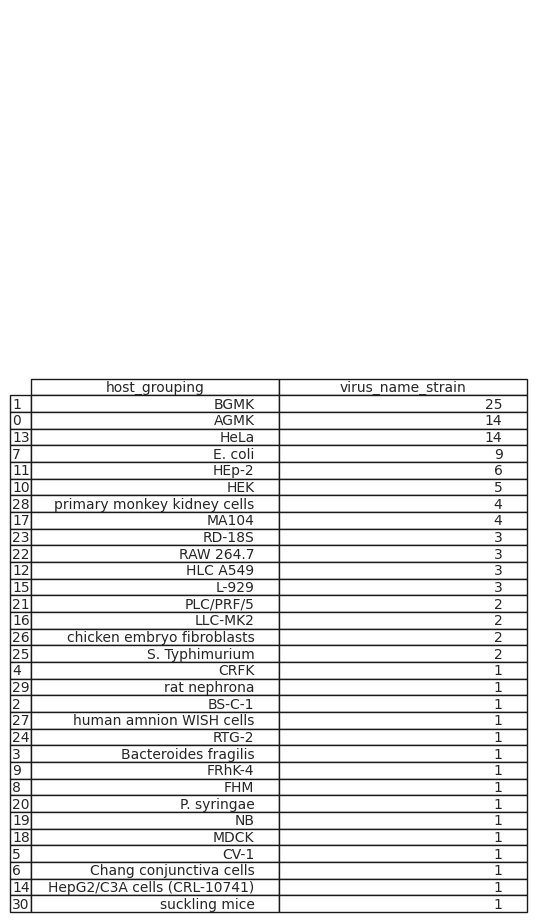

In [ ]:
#(merged_dataset_temp.groupby('virus_name_abbrev')['host_grouping'].unique().reset_index())
host_grouping_unique = merged_dataset_temp.groupby('host_grouping')['virus_name_strain'].nunique().reset_index()
host_grouping_unique = host_grouping_unique.sort_values(by = 'virus_name_strain', ascending=False)


ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, host_grouping_unique)  # where df is your data frame

plt.savefig('mytable.png')


In [ ]:
host_cell_use = (merged_dataset_temp.groupby('host_cell')['virus_name_abbrev'].unique().reset_index())
host_cell_use.to_csv('host_cell_use.csv')

from google.colab import files
files.download('host_cell_use.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
merged_dataset[merged_dataset['host_cell'].isnull()]
merged_dataset.loc[merged_dataset['host_cell']=='',:]


,virus_name_strain,temp,pH,paper_ID,purification_level,sample_ID,year,author_list,buffer_type,corr_author,...,virus_name_full,virus_name_abbrev,first_author,first_author_and_year,log_average_kobs,year_float,year_int,float_year_scaled,int_year_scaled,host_grouping
22,ms2,21.0,7.4,9,3,9-1,2018,"['ikehata_k', 'li_y', 'komor_a', 'gibson_g']",wastewater,ikehata_k,...,MS2 bacteriophage,MS2 bacteriophage,ikehata_k,ikehata_k 2018,0.855337,2018.0,2018,2.9,2.9,E. coli
206,ms2,18.0,7.3,43,3,43-1,1998,"['haas_c', 'joffe_j', 'heath_m', 'jacangelo_j'...",surface water,haas_c,...,MS2 bacteriophage,MS2 bacteriophage,haas_c,haas_c 1998,0.347514,1998.0,1998,0.9,0.9,E. coli
407,f2,23.5,5.6,64,3,64-1,1979,"['dennis jr._w', 'olivieri_v', 'krusé_c']",phosphate,dennis jr._w,...,f2 bacteriophage,f2 bacteriophage,dennis jr._w,dennis jr._w 1979,2.477105,1979.0,1979,-1.0,-1.0,E. coli
408,f2,23.5,7.6,64,3,64-2,1979,"['dennis jr._w', 'olivieri_v', 'krusé_c']",phosphate,dennis jr._w,...,f2 bacteriophage,f2 bacteriophage,dennis jr._w,dennis jr._w 1979,1.447071,1979.0,1979,-1.0,-1.0,E. coli
409,f2,23.5,9.9,64,3,64-3,1979,"['dennis jr._w', 'olivieri_v', 'krusé_c']",phosphate,dennis jr._w,...,f2 bacteriophage,f2 bacteriophage,dennis jr._w,dennis jr._w 1979,0.769407,1979.0,1979,-1.0,-1.0,E. coli
421,t5,5.0,10.0,69,2,69-10,1973,"['scarpino_p', 'dahling_d', 'lucas_m', 'berg_g...",borate,berg_g,...,T5 bacteriophage,T5 bacteriophage,scarpino_p,scarpino_p 1973,1.689096,1973.0,1973,-1.6,-1.6,E. coli
422,t5,5.0,6.0,69,2,69-11,1973,"['scarpino_p', 'dahling_d', 'lucas_m', 'berg_g...",phosphate,berg_g,...,T5 bacteriophage,T5 bacteriophage,scarpino_p,scarpino_p 1973,2.585590,1973.0,1973,-1.6,-1.6,E. coli
424,f2,5.0,6.0,69,2,69-3,1973,"['scarpino_p', 'dahling_d', 'lucas_m', 'berg_g...",phosphate,berg_g,...,f2 bacteriophage,f2 bacteriophage,scarpino_p,scarpino_p 1973,1.548796,1973.0,1973,-1.6,-1.6,E. coli
425,f2,5.0,10.0,69,2,69-4,1973,"['scarpino_p', 'dahling_d', 'lucas_m', 'berg_g...",borate,berg_g,...,f2 bacteriophage,f2 bacteriophage,scarpino_p,scarpino_p 1973,1.756566,1973.0,1973,-1.6,-1.6,E. coli
426,ms2,5.0,10.0,69,2,69-5,1973,"['scarpino_p', 'dahling_d', 'lucas_m', 'berg_g...",borate,berg_g,...,MS2 bacteriophage,MS2 bacteriophage,scarpino_p,scarpino_p 1973,1.471275,1973.0,1973,-1.6,-1.6,E. coli


In [ ]:
merged_dataset_host = merged_dataset.groupby('virus_name_abbrev')['host_cell'].unique().reset_index()


# Save the DataFrame as a CSV file
merged_dataset_host.to_csv('merged_dataset_host.csv')

from google.colab import files
#files.download('merged_dataset_host.csv')



In [ ]:
merged_dataset.columns

Index(['virus_name_strain', 'temp', 'pH', 'paper_ID', 'purification_level',
       'sample_ID', 'year', 'author_list', 'buffer_type', 'corr_author',
       'high_chloride', 'buffer_description', 'host_cell', 'high_chloride_new',
       'phosphate_assumption_needed', 'Sample_ID', 'Method_R1', 'Coef_np_R1',
       'Coef_OLS_R1', 'Standard_Error_R1', 'Data_Points_Used_R1', 'Diff_R1',
       'Data_Points_R1', 'smaller_than_R1', 'Method_R2', 'Coef_np_R2',
       'Coef_OLS_R2', 'Standard_Error_R2', 'Data_Points_Used_R2', 'Diff_R2',
       'smaller_than_R2', 'larger_than_R2', 'average_kobs', 'diff',
       'Difference', 'alpha_0', 'buffer', 'balt_class', 'family', 'genus',
       'species', 'structure', 'symmetry', 'tail', 'diameter', 'CG_content',
       'genome_length', 'C_percentage', 'G_percentage', 'A_percentage',
       'T_percentage', 'U_percentage', 'T_is_0', 'U_is_0', 'virus_name_full',
       'virus_name_abbrev', 'first_author', 'first_author_and_year',
       'log_average_kobs', 'y

In [ ]:
merged_dataset.loc[merged_dataset['paper_ID'] == 57]['host_grouping']


312                      PLC/PRF/5
313    primary monkey kidney cells
314    primary monkey kidney cells
315    primary monkey kidney cells
316    primary monkey kidney cells
317    primary monkey kidney cells
318    primary monkey kidney cells
319                      PLC/PRF/5
320                      PLC/PRF/5
321                        E. coli
322                        E. coli
323                        E. coli
324                           BGMK
325                           BGMK
326                           BGMK
Name: host_grouping, dtype: object

#Export Dataset

In [ ]:
len(sorted(merged_dataset.host_grouping.unique()))
df['host_grouping'].isnull().sum()


0

In [ ]:
merged_dataset = merged_dataset_temp

merged_dataset.loc[merged_dataset['paper_ID'] == 57]['host_grouping']


312                      PLC/PRF/5
313    primary monkey kidney cells
314    primary monkey kidney cells
315    primary monkey kidney cells
316    primary monkey kidney cells
317    primary monkey kidney cells
318    primary monkey kidney cells
319                      PLC/PRF/5
320                      PLC/PRF/5
321                        E. coli
322                        E. coli
323                        E. coli
324                           BGMK
325                           BGMK
326                           BGMK
Name: host_grouping, dtype: object

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import files

merged_dataset_test = merged_dataset.copy().fillna('').reset_index(drop = True)

values = [merged_dataset_test.columns.values.tolist()] + merged_dataset_test.values.tolist()

sheet = gc.create('Revisions_merged_dataset_postprocessing.xlsx').sheet1
sheet.update(values)


#merged_dataset_test.to_csv("merged_dataset_test.csv")
#files.download("merged_dataset_test.csv")

{'spreadsheetId': '1c-60N51ivQRastAEtl0pJ7G_MhoB9yVq72_IaEki8O0',
 'updatedRange': 'Sheet1!A1:BL571',
 'updatedRows': 571,
 'updatedColumns': 64,
 'updatedCells': 36544}